# Analysing the Broken Windows in DC neigborhoods

In 1969 Philip Zimbardo decided to tryout a social experiment about disorder. He abandoned two cars, one in a rough neighborhood in New York City and one in a affluent neighborhood in California. Unsurprisingly the car in the bad part of town got stripped and vandalized where the one in California did not. Zimbardo then smashed up the California car and observed that then it was stripped and vandalized. Then a few years later George L. Kelling and James Q. Wilson wrote and article in the Atlantic, they thought these findings could be extrapolated. They were most intrigued by how the experiment observed that once “disorder” begins things unravel quickly. They theorized that if policing stopped chasing the big crimes and focused on small petty crimes like vandalism or broken windows then the police could prevent the big crimes. This theory than informed Rudy Giuliani’s  run as may of New York to clean up the town and it seemed to be working really well. In fact it quickly spread to other metro areas, it has sense been proven that the drop in crime had little to do with this strategy but it still remains popular. 

My goal was to use DC data on metro crimes and service requests to see if we can observe what Zimbardo was originally trying to observe. We looked at service requests that would qualify as “broken windows” that would include graffiti, abandoned cars, homeless encampments and illegal dumping.  The goal was to use this service request to predict crime totals in a Bayesian regression with the goal of observing if an increase in the number of broken windows results in a increase in the rate of crime.



The first hurdle we needed to clear was generating features for our crime and service observation. So for each crime we had we needed to generate a number of broken window events in the area and then calculate the crime totals in the area over the same period. This proved challenging from a computation standpoint. Doing that much great circle distance calculations takes time so function optimization was important. I settled on observing broken windows and crime in a 10 day period before our observation and at a ½ distance from observation. This is because the city estimates service call response time at 10 days and ½ a mile is about 4 blocks in DC. The model we built later can be updated to try different time and distance measures. 


Exploratory data analysis was next. I needed to understand the spread of crime and service calls across the city to make sure our service calls weren’t only coming from certain areas and that did not seem to be the case. The most useful observation was the jump in broken window events from before 2012 and after. It turns out that was when the city rolled out their 311 app making it easier than ever for citizens to make 311 requests. Having that information in hand it would make sense to model for both and before and after this period and compare our posterior distribution.

Now we were ready to use the pymc library to fit our model. Now pymc is designed for small data sets and our post app roll out set had so many observation that it broke our model. So instead we sampled randomly from the years 2012-2016 18k for each year. Our results were interesting, for our model before the app we actually observed an average of a negative correlation of broken window events to crimes and after the app it had a slight positive correlation. I am hypothesizing that broken window events don’t actually have an impact on crime. 

Now challenges and limitations with this approach are many and various. First the service request line can’t be filtered for two people observing the same broken window event. We also need to consider the kind of resident that makes these kind of service requests and that we are not physically observing there broken windows event. Moving forward the hope would be to source additional broken window data and data from more locations. 

Broken windows as a foundation of police policy has been discredited with multiple studies since, our findings seem to support that as well. Hopefully I can continue to refine this model and influence the way people view crime in the communities. Broken windows was used as a excuse to harass low income areas and lock up small time offenders. Broken windows grew in popularity due to our need for simple clean solutions to very complex problems. 


In [30]:
# esential items
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
import numpy as np
import time
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# eda libraries and items
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler



# Modeling stuff
from pymc3 import *



#### Lets read in our data, opendata.dc.gov has the data we will be using from there metro police and 311 serivce requests. 


In [68]:
crdf = pd.read_csv('../crime_df09_17.csv')
srdf = pd.read_csv('../service_df09_17.csv')

## Data Munging

In [4]:
def eda(dataframe):
    # This eda Ritika Bhasker's eda function github.com/ritikabhasker/how-to-guides
    # Its the best
    print "Missing Values \n \n", dataframe.isnull().sum(),"\n"
    print "Duplicate Rows \n", dataframe.duplicated().sum(),"\n" 
    print "Dataframe Types \n \n", dataframe.dtypes,"\n"
    print "Dataframe Shape \n", dataframe.shape,"\n"
    print "Dataframe Describe \n \n", dataframe.describe(include='all'),"\n"
    for feature in dataframe:
        print feature
        print dataframe[feature].nunique()

In [5]:
eda(crdf)

Missing Values 
 
Unnamed: 0                   0
X                            0
Y                            0
CCN                          0
REPORT_DAT                   0
SHIFT                        0
METHOD                       0
OFFENSE                      0
BLOCK                        0
XBLOCK                       0
YBLOCK                       0
WARD                        13
ANC                          0
DISTRICT                   174
PSA                        213
NEIGHBORHOOD_CLUSTER      4055
BLOCK_GROUP                954
CENSUS_TRACT               954
VOTING_PRECINCT             78
XCOORD                    5190
YCOORD                    5190
LATITUDE                     0
LONGITUDE                    0
BID                     253655
START_DATE                  10
END_DATE                 11321
OBJECTID                     0
dtype: int64 

Duplicate Rows 
0 

Dataframe Types 
 
Unnamed: 0                int64
X                       float64
Y                       flo

10
START_DATE
237776
END_DATE
245999
OBJECTID
301970


In [6]:
eda(srdf)

Missing Values 
 
Unnamed: 0                        0
X                                 0
Y                                 0
OBJECTID                          0
SERVICECODE                       0
SERVICECODEDESCRIPTION            0
SERVICETYPECODEDESCRIPTION       31
ORGANIZATIONACRONYM               0
SERVICECALLCOUNT                  0
ADDDATE                           0
RESOLUTIONDATE                 4910
SERVICEDUEDATE                    4
SERVICEORDERDATE                  0
INSPECTIONFLAG                    0
INSPECTIONDATE                35059
INSPECTORNAME                 53000
SERVICEORDERSTATUS               31
STATUS_CODE                   17984
SERVICEREQUESTID                  0
PRIORITY                       1048
STREETADDRESS                  2800
XCOORD                            0
YCOORD                            0
LATITUDE                        547
LONGITUDE                       547
CITY                           3298
STATE                          3298
ZIPCODE   

#### PREP ON SERVICE DF.

In [69]:
srdf['SERVICECODEDESCRIPTION'].unique()
# we already filtered the the service data by relevant broken windows events,
# but on further reveiw we should drop a few more

array(['Graffiti Removal', 'Graffiti Removal - Paint Voucher Request',
       'Abandoned Vehicle - On Private Property',
       'Abandoned Vehicle - On Public Property', 'Illegal Dumping',
       'Homeless Encampment', 'Abandoned Bicycle',
       'Graffiti Removal-Paint Voucher Request'], dtype=object)

In [70]:
srdf = srdf[(srdf['SERVICECODEDESCRIPTION'] == 'Graffiti Removal') | (srdf['SERVICECODEDESCRIPTION'] == 
             'Abandoned Vehicle - On Private Property') | (srdf['SERVICECODEDESCRIPTION'] == 
             'Abandoned Vehicle - On Public Property') | (srdf['SERVICECODEDESCRIPTION'] == 
             'Illegal Dumping') 
            | (srdf['SERVICECODEDESCRIPTION'] == 'Homeless Encampment')
             | (srdf['SERVICECODEDESCRIPTION'] == 'Abandoned Bicycle')]

In [71]:
srdf['SERVICECODEDESCRIPTION'].value_counts()

Illegal Dumping                            23928
Abandoned Vehicle - On Public Property     20392
Graffiti Removal                           16224
Abandoned Vehicle - On Private Property     7167
Abandoned Bicycle                           1897
Homeless Encampment                           68
Name: SERVICECODEDESCRIPTION, dtype: int64

In [72]:
srdf = srdf.dropna(subset=['SERVICEDUEDATE'])
# service due date will be the time we chose to use as our measurment so lets drop nulls from that column, not mush lost.

In [73]:
srdf['Date'] = [x[0:10] for x in srdf['SERVICEDUEDATE']]
# parsing the relevant date information

In [74]:
srdf['Date'] = pd.to_datetime(srdf['Date'])
# lets make it datetime format

In [75]:
srdf = srdf.dropna(subset=['LATITUDE','LONGITUDE'])
# also we have to drop nulls from lat long, these will be our measure of space.

In [76]:
srdf = srdf.drop_duplicates()
# this is a cause for future work we need to devise a way to filter out calls for the same broken window event
# unitl then best we can do is drop any duplicates we have

In [77]:
srdf.head()

,Unnamed: 0,X,Y,OBJECTID,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODEDESCRIPTION,ORGANIZATIONACRONYM,SERVICECALLCOUNT,ADDDATE,RESOLUTIONDATE,SERVICEDUEDATE,SERVICEORDERDATE,INSPECTIONFLAG,INSPECTIONDATE,INSPECTORNAME,SERVICEORDERSTATUS,STATUS_CODE,SERVICEREQUESTID,PRIORITY,STREETADDRESS,XCOORD,YCOORD,LATITUDE,LONGITUDE,CITY,STATE,ZIPCODE,MARADDRESSREPOSITORYID,WARD,DETAILS,Date
0,18,-77.074151,38.913551,701703,GRAFF,Graffiti Removal,Graffiti,DPW,1,2009-01-16T17:35:18.000Z,2014-09-25T12:59:45.000Z,2009-01-30T17:35:18.000Z,2009-01-16T17:35:18.000Z,Y,2014-09-25T12:59:46.000Z,"Bowden, Lasharn",CLOSED,CLOSED,09-02016407,STANDARD,NaN,393569.240056,138411.320030,38.913543,-77.074149,WASHINGTON,DC,20007.0,NaN,2.0,GRAFF ~COMMENTS - PARKING SIGN DEFACED WITH GR...,2009-01-30
1,19,-77.068629,38.905083,701704,GRAFF,Graffiti Removal,Graffiti,DPW,1,2009-01-09T08:47:35.000Z,2014-09-25T12:56:49.000Z,2009-01-23T08:47:35.000Z,2009-01-09T08:47:35.000Z,Y,2014-09-25T12:56:50.000Z,"Bowden, Lasharn",CLOSED,CLOSED,09-02009851,STANDARD,NaN,394047.492952,137470.966333,38.905076,-77.068627,WASHINGTON,DC,20007.0,NaN,2.0,GRAFF ~COMMENTS - TWO TRAFFIC CONTROL BOXES DE...,2009-01-23
2,20,-77.081614,38.949695,701705,GRAFF,Graffiti Removal,Graffiti,DPW,1,2009-01-20T15:36:02.000Z,2014-09-25T13:00:53.000Z,2009-02-03T15:36:02.000Z,2009-01-20T15:36:02.000Z,Y,2014-09-25T13:00:53.000Z,"Bowden, Lasharn",CLOSED,CLOSED,09-02016987,STANDARD,NaN,392925.599991,142424.200002,38.949688,-77.081612,WASHINGTON,DC,20016.0,NaN,3.0,GRAFF ~COMMENTS - ~LOC - GRAFFITI ON EAST-FAC...,2009-02-03
9,103,-77.045176,38.932286,706668,S0003,Abandoned Vehicle - On Private Property,Abandoned Vehicle Operations - Private,DPW,1,2009-12-31T00:36:11.000Z,2014-10-02T09:48:52.000Z,2010-03-15T00:36:11.000Z,2009-12-31T00:36:11.000Z,Y,2013-10-02T23:00:45.000Z,NaN,CLOSED,CLOSED,09-03188751,STANDARD,3225 WALBRIDGE PLACE NW,396083.210000,140489.380000,38.932278,-77.045174,WASHINGTON,DC,20010.0,233384.0,1.0,Adminstrative Closing\n\n3rd request on these ...,2010-03-15
10,410,-77.023227,38.916113,707209,S0000,Abandoned Vehicle - On Public Property,Abandoned Vehicle Operations - Public,DPW,1,2009-12-04T19:23:45.000Z,2014-10-02T09:16:29.000Z,2009-12-22T19:23:45.000Z,2009-12-04T19:23:45.000Z,Y,2013-10-02T23:00:45.000Z,NaN,CLOSED,CLOSED,09-03161919,STANDARD,1914 8TH STREET NW,397985.830000,138693.410000,38.916106,-77.023225,WASHINGTON,DC,20001.0,239843.0,1.0,Adminstrative Closing\n\nappears to have been ...,2009-12-22


In [ ]:
#srdf.to_csv('service_cleaned.csv', index = False)
# lets save our cleaned data to a csv, we endedup dropping 5% of our data.

#### LETS DO THIS PREP ON CRIME DF.

In [44]:
crdf['Date'] = [x[0:10] for x in crdf['REPORT_DAT']]
# The obvious time measurment 

In [45]:
crdf['Date'] = pd.to_datetime(crdf['Date'])
# to datetime format

In [46]:
srdf = srdf.dropna(subset=['LATITUDE','LONGITUDE'])
# also we have to drop nulls from lat long, these will be our measure of space.

In [47]:
crdf = crdf.drop_duplicates()

In [48]:
crdf.head()

,Unnamed: 0,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,XCOORD,YCOORD,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,Date
0,0,-77.031960,38.903136,90096755,2009-07-10T18:30:00.000Z,EVENING,OTHERS,THEFT/OTHER,1000 - 1099 BLOCK OF 14TH STREET NW,397228.00,137253.00,2.0,2F,1.0,101.0,Cluster 8,010100 1,10100.0,Precinct 129,397260.09,137229.87,38.903128,-77.031958,DOWNTOWN,2009-07-10T11:00:00.000Z,2009-07-10T17:00:00.000Z,61028589,2009-07-10
1,1,-76.947212,38.903975,99168068,2009-11-25T23:30:00.000Z,MIDNIGHT,OTHERS,THEFT F/AUTO,3500 - 3899 BLOCK OF JAY STREET NE,404579.00,137347.00,7.0,7D,6.0,601.0,Cluster 30,009602 1,9602.0,Precinct 100,404536.18,137328.87,38.903967,-76.947209,NaN,2009-11-25T08:30:00.000Z,2009-11-25T19:30:00.000Z,61028591,2009-11-25
2,2,-76.939207,38.895197,99438989,2009-06-23T00:00:00.000Z,MIDNIGHT,OTHERS,HOMICIDE,400 - 499 BLOCK OF 44TH STREET NE,405274.00,136373.00,7.0,7D,6.0,602.0,Cluster 30,007803 4,7803.0,Precinct 99,405253.54,136393.83,38.895189,-76.939204,NaN,1999-08-01T04:00:00.000Z,1999-08-02T00:00:00.000Z,61028592,2009-06-23
3,3,-76.999518,38.904689,162302,2009-11-12T18:00:00.000Z,EVENING,OTHERS,MOTOR VEHICLE THEFT,1100 - 1199 BLOCK OF 5TH STREET NE,400042.00,137425.00,6.0,6C,1.0,104.0,Cluster 25,010600 2,10600.0,Precinct 83,400020.34,137466.29,38.904682,-76.999516,NaN,2009-11-06T12:00:00.000Z,2009-11-12T17:00:00.000Z,61032441,2009-11-12
4,4,-77.022948,38.917244,174072,2009-12-06T23:30:00.000Z,MIDNIGHT,OTHERS,THEFT F/AUTO,2000 - 2099 BLOCK OF 8TH STREET NW,398010.08,138818.94,1.0,1B,3.0,305.0,Cluster 3,003500 2,3500.0,Precinct 37,398010.13,138762.60,38.917236,-77.022946,NaN,2009-12-06T21:30:00.000Z,2009-12-06T23:30:00.000Z,61032442,2009-12-06


In [ ]:
# crdf.to_csv('crime_cleaned.csv', index = False)
# save to csv for safe keeping we dropped 2% of our data that were dups

## Lets engineer our features that will be our x and y.

In [49]:
crdfsample = crdf.sample(frac=.01, replace=False, random_state=75)
srdfsample = srdf.sample(frac=.01, replace=False, random_state=75)
# lets make 1% samples to make sure our functions work right, the lat lon math we will do is time intensive.

In [50]:
# Define a basic Haversine distance formula, I found that this is much faster than using libraries like Geopy.
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

In [51]:
def service_event(crime, service, timelag = 10, distance = .50):

    service_score_list = []

    for crime_index in tqdm_notebook(crime.index):
        count = 0
        crime_date = crime.get_value(crime_index, 'Date')
        crime_lat = crime.get_value(crime_index, 'LATITUDE')
        crime_lon = crime.get_value(crime_index, 'LONGITUDE')

        curr_service = service[(service.Date >= crime_date - pd.Timedelta(timelag,unit='d')) 
                                & (service.Date <= crime_date)]
        
        curr_service['distance'] = haversine(crime_lat,crime_lon,curr_service['LATITUDE'].values, curr_service['LONGITUDE'].values)



               
        for curr_service_index in curr_service.index:
            curr_service_distance = curr_service.get_value(curr_service_index, 'distance')
            if curr_service_distance <= distance:
                count += 1
        service_score_list.append(count)

    return service_score_list

# This is our function. It took me awhile to optimize this so that it would run in less than 5 hrs. This presents scaling 
# problems and trying to generate this with more years of data will take awhile. 
#  For each crime we want to see if there was a broken window event 10 days(that is the cites quote on reponse time)
#  beofre the crime and within 1/2 mileor about 4 blocks in a straight line.

In [52]:
def crime_totals(crime, timelag = 10, distance = .50):

    crime_score_list = []

    for crime_index in tqdm_notebook(crime.index):
        count = 0
        crime_date = crime.get_value(crime_index, 'Date')
        crime_lat = crime.get_value(crime_index, 'LATITUDE')
        crime_lon = crime.get_value(crime_index, 'LONGITUDE')

        curr_crime = crime[(crime.Date >= crime_date - pd.Timedelta(timelag,unit='d')) 
                                & (crime.Date <= crime_date)]
        
        curr_crime['distance'] = haversine(crime_lat,crime_lon,curr_crime['LATITUDE'].values, curr_crime['LONGITUDE'].values)



               
        for curr_crime_index in curr_crime.index:
            curr_crime_distance = curr_crime.get_value(curr_crime_index, 'distance')
            if curr_crime_distance <= distance:
                count += 1
        crime_score_list.append(count)

    return crime_score_list
# Here we use the same function but now for each crime we want a 
# total of all crimes that happened in the area same as the broken windows.

In [53]:
%lprun -f service_event onecentsample_srft = service_event(crdfsample, srdfsample)
# %lprun -f service_event full_srft = service_event(crdf, srdf)
# lpurn gives us a print out that shows how our function is performaing line by line, how cool is that?!

/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
%lprun -f crime_totals onecentsample_crft = crime_totals(crdfsample)
# %lprun -f crime_totals full_crft = crime_totals(crdf)

/Users/natalie/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
crdfsample['Service_event_full'] = onecentsample_srft
crdfsample['Crime_totals']  = onecentsample_crft
# crdf['Service_event_full'] = full_srft
# crdf['Crime_totals']  = full_crft

In [ ]:
# crdf.to_csv('crime_full.csv', index = False)
# lets also save our csv here safe keeping

### Some EDA

EDA is an imortant part of the data science work flow. For this project alot of our eda took the form of summary stats we see in our eda function out put. I also conducted research on the topic of Broken Windows Theroy,the research behind it and how it was implemnted in cities around the country. 

(array([ 2835.,     0.,     0.,   156.,     0.,     0.,    26.,     0.,
            0.,     3.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

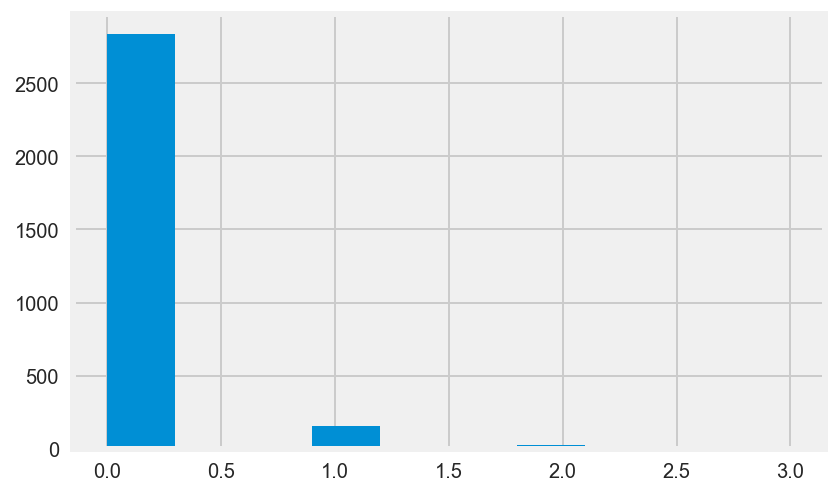

In [56]:
plt.hist(crdfsample['Service_event_full'])
#on our small sample data there isnt alot of variation, but on the full set you will see a large spread.
# And the jump in broken windows events corisponds to the cities roll out of the 311 app.

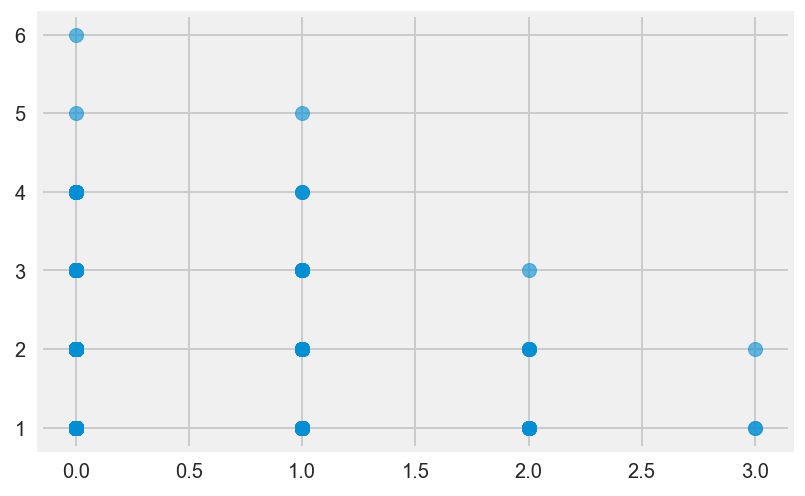

In [62]:
x=crdfsample['Service_event_full']
y=crdfsample['Crime_totals']
plt.scatter(x,y,alpha=.6)
plt.xkcd
plt.show()


(array([ 446.,  546.,  165.,    0.,  298.,  406.,    0.,  445.,  355.,  359.]),
 array([ 1. ,  1.7,  2.4,  3.1,  3.8,  4.5,  5.2,  5.9,  6.6,  7.3,  8. ]),
 <a list of 10 Patch objects>)

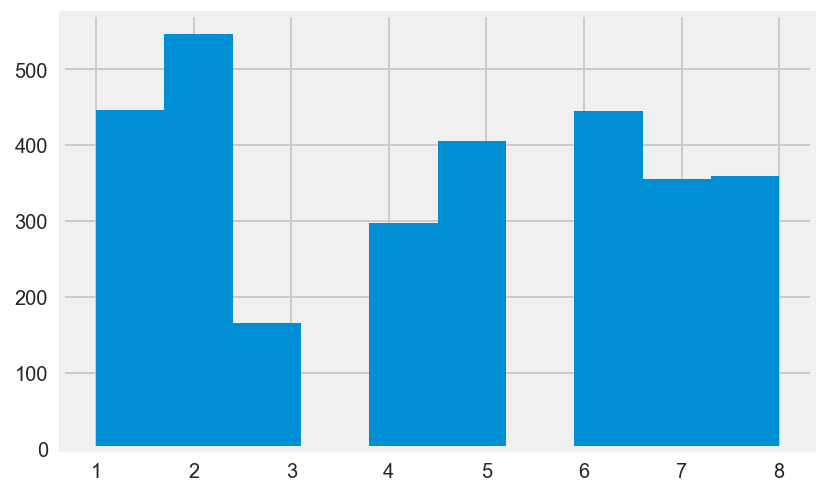

In [66]:
plt.hist(crdfsample['WARD'])

(array([ 2.,  1.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([  0. ,   7.7,  15.4,  23.1,  30.8,  38.5,  46.2,  53.9,  61.6,
         69.3,  77. ]),
 <a list of 10 Patch objects>)

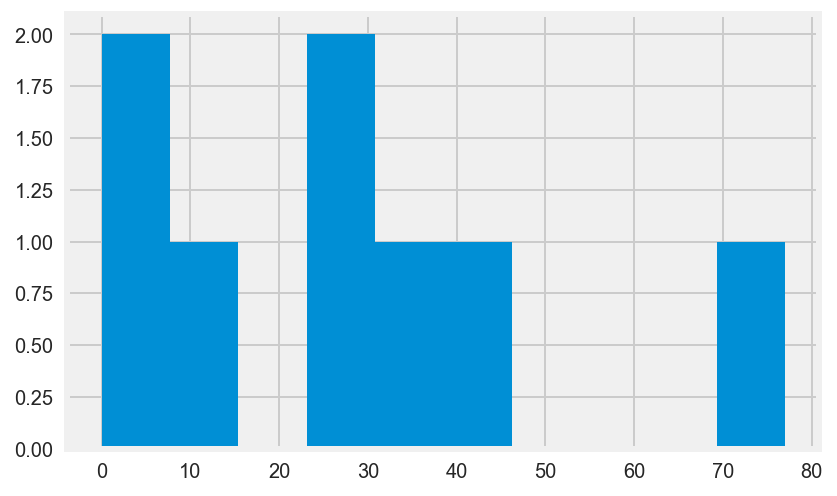

In [82]:
plt.hist(crdfsample.groupby(['WARD'])['Service_event_full'].sum())

In [89]:
crdfsample['year'] = crdfsample['Date'].dt.year
# crdf['year'] = crdf['Date'].dt.year
# lets make a year column to filter our frame by pre app and post app

### Lets model with pymc to get our posterior distribution.

In [90]:
crdf_pre11 = crdfsample[crdfsample['year'] <= 2011]
crdf_post11 = crdfsample[crdfsample['year'] >= 2012]
# crdf_pre11 = crdf[crdf['year'] <= 2011]
# crdf_post11 = crdf[crdf['year'] >= 2012]

In [91]:
crdf_post11['year'].value_counts()

2015    388
2014    388
2016    362
2013    360
2012    338
2017    231
Name: year, dtype: int64

In [93]:
crdf_post11 = crdf_post11[crdf_post11['year'] < 2017]
# crdf_post11 = crdf_post11[crdf_post11['year'] < 2017]
# lets drop 2017

In [95]:
crdf_12 = crdf_post11[crdf_post11['year'] == 2012]
crdf_13 = crdf_post11[crdf_post11['year'] == 2013]
crdf_14 = crdf_post11[crdf_post11['year'] == 2014]
crdf_15 = crdf_post11[crdf_post11['year'] == 2015]
crdf_16 = crdf_post11[crdf_post11['year'] == 2016]
# The observations for the full data are to many observations for pymc so we need to random sample 18k per year, 

In [97]:
# crdf_12 = crdf_12.sample(18800)
# crdf_13 = crdf_13.sample(18800)
# crdf_14 = crdf_14.sample(18800)
# crdf_15 = crdf_15.sample(18800)
# crdf_16 = crdf_16.sample(18800)
#  these samplings are only required on the full data set.

In [98]:
crdf_post11 = pd.concat([crdf_12,crdf_13,crdf_14,crdf_15,crdf_16])
# now we have our sample to model for before the app went live.

### Post app roll out model

In [99]:
x = crdf_post11['Service_event_full']

y = crdf_post11['Crime_totals']
# x2 = crdf_post11['yearfct'] '"this is for later tinkering I wanted to add year, month, and ward"'

data = dict(x=x, y=y)

In [100]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = Uniform('sigma', lower = 0, upper = 50)
    intercept = Normal('Intercept', 0, sd=30)
    x_coeff = Normal('x', 0, sd=1)
    

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)

    # Inference!
    trace = sample(2000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 1,785.2:  11%|█         | 21430/200000 [00:02<00:22, 8039.90it/s]
Convergence archived at 22200
INFO:pymc3.variational.inference:Convergence archived at 22200
Interrupted at 22,200 [11%]: Average Loss = 3,724.1
INFO:pymc3.variational.inference:Interrupted at 22,200 [11%]: Average Loss = 3,724.1
100%|██████████| 2500/2500 [00:08<00:00, 283.86it/s]


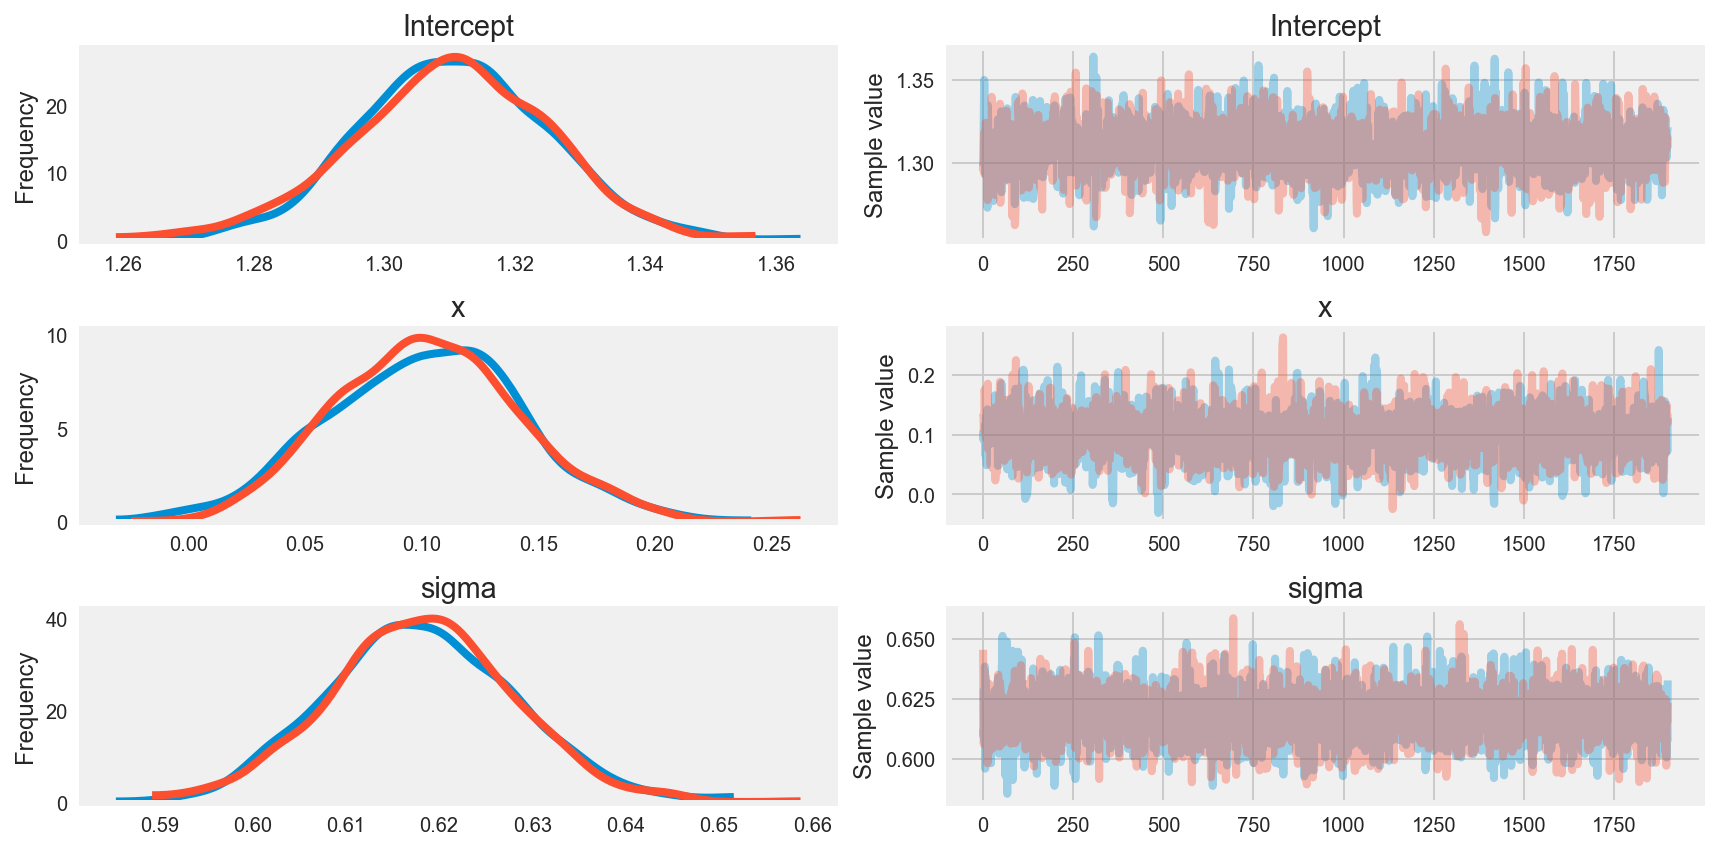

In [101]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [102]:
summary(trace[100:])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.310            0.015            0.000            [1.281, 1.340]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.279          1.301          1.311          1.321          1.340


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.101            0.041            0.001            [0.021, 0.179]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.024          0.073          0.102          0.128          0.182


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1206384d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1213f7550>], dtype=object)

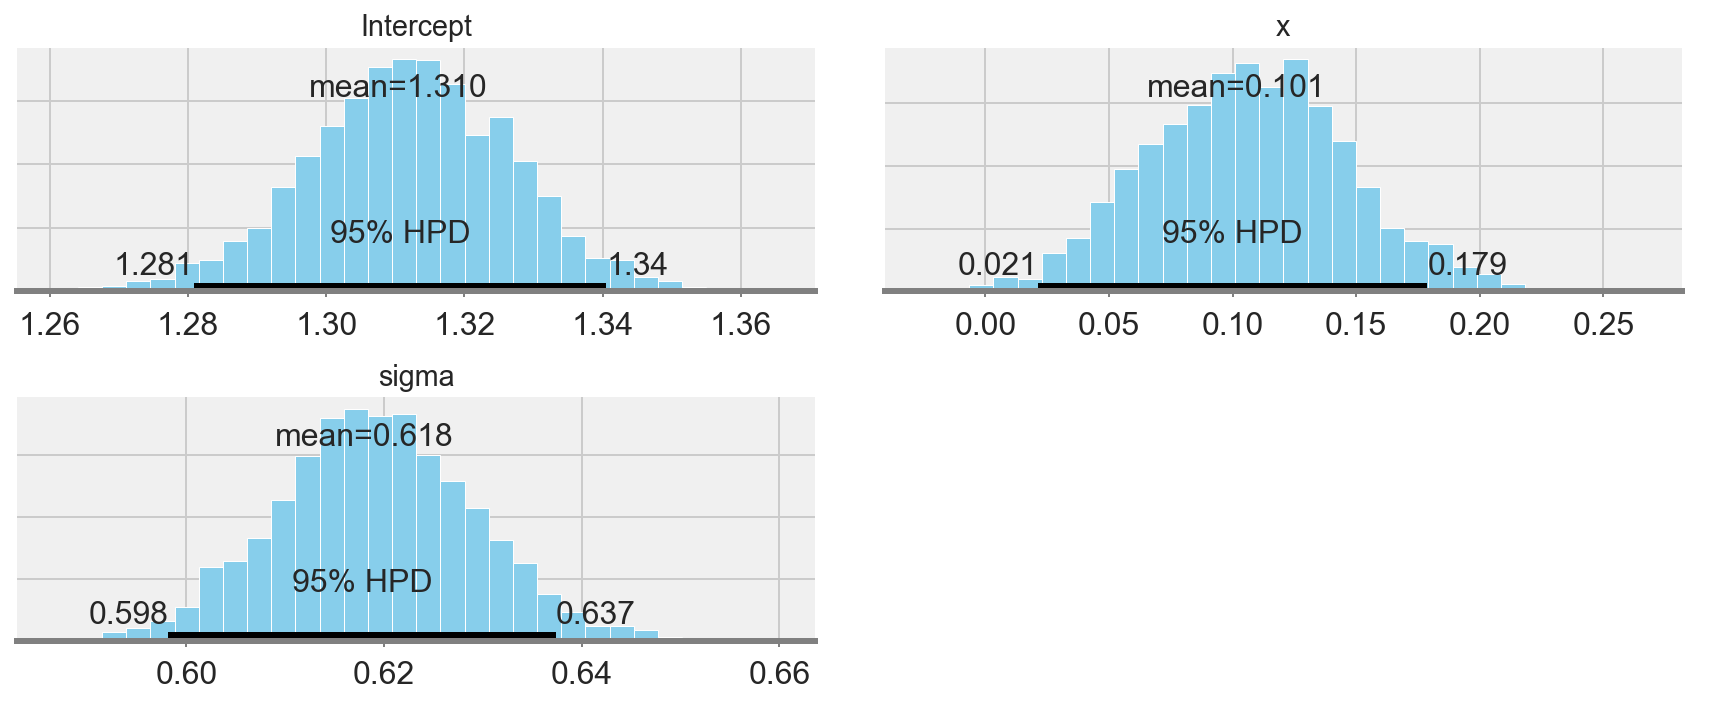

In [103]:
plot_posterior(trace[100:], color = '#87ceeb')

### Lets model or pre app rollout model

In [104]:
x = crdf_pre11['Service_event_full']

y = crdf_pre11['Crime_totals']

data = dict(x=x, y=y)

In [105]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = Uniform('sigma', lower = 0, upper = 50)
    intercept = Normal('Intercept', 0, sd=30)
    x_coeff = Normal('x', 0, sd=1)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    trace = sample(2000, njobs=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 776.23:  14%|█▍        | 28482/200000 [00:03<00:19, 9017.14it/s] 
Convergence archived at 29200
INFO:pymc3.variational.inference:Convergence archived at 29200
Interrupted at 29,200 [14%]: Average Loss = 1,618.5
INFO:pymc3.variational.inference:Interrupted at 29,200 [14%]: Average Loss = 1,618.5
100%|██████████| 2500/2500 [00:04<00:00, 532.37it/s]


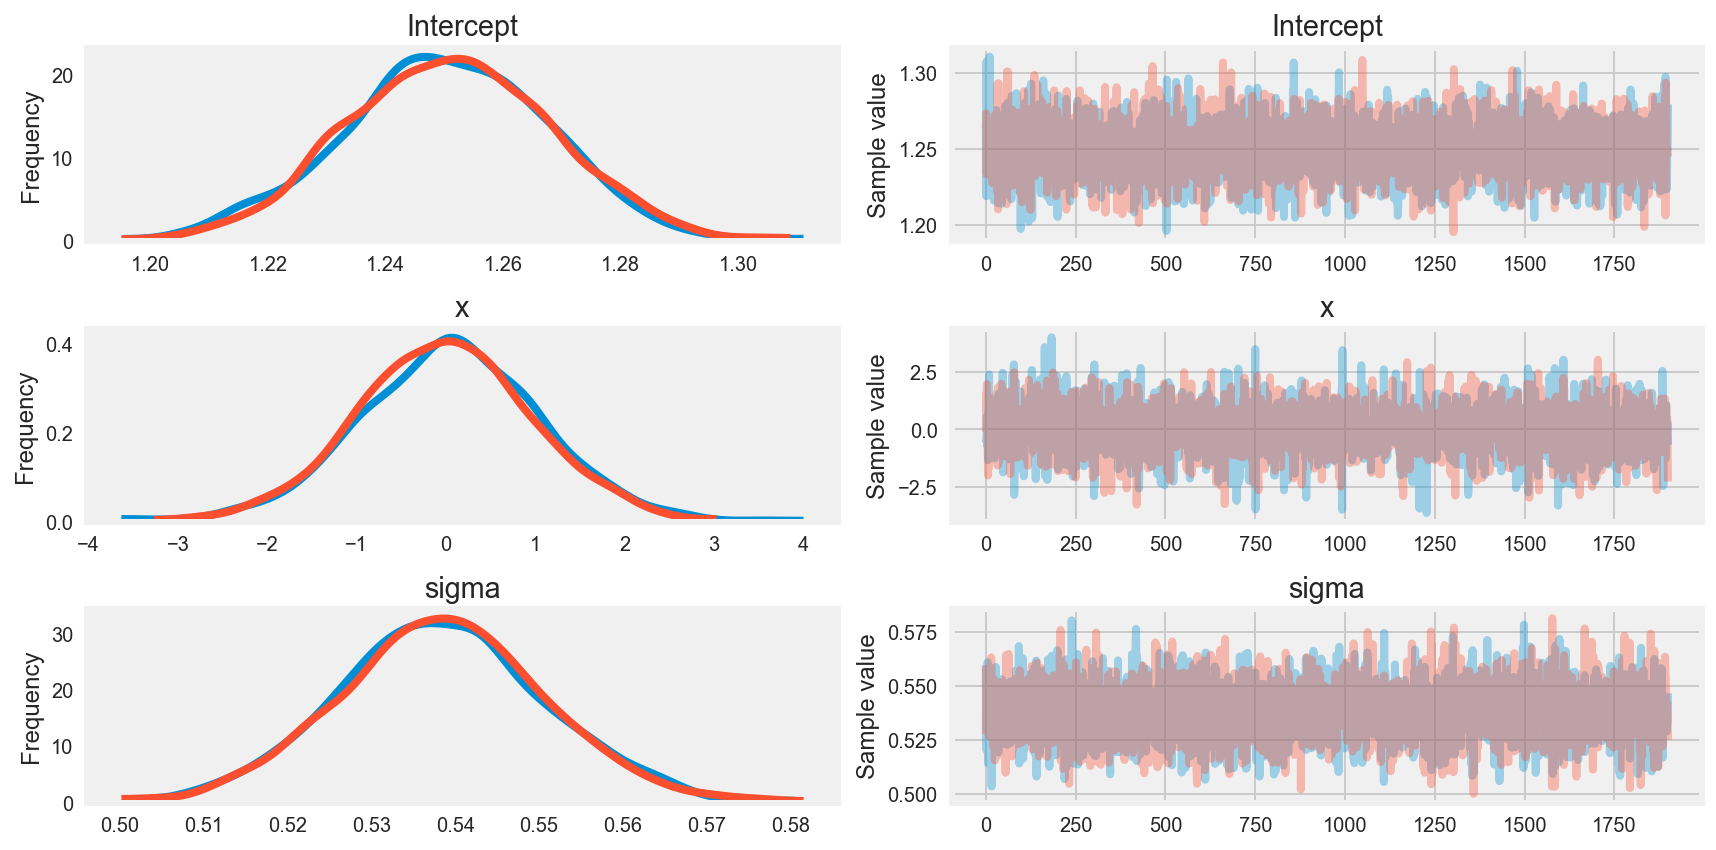

In [106]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [107]:
summary(trace[100:])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.250            0.017            0.000            [1.215, 1.283]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.215          1.239          1.250          1.262          1.284


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.011            0.996            0.018            [-1.861, 2.061]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.993         -0.647         0.019          0.666          1.964


sigma:

  Mean             SD               MC Error         95% HPD interval
  ------------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125069f90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1256362d0>], dtype=object)

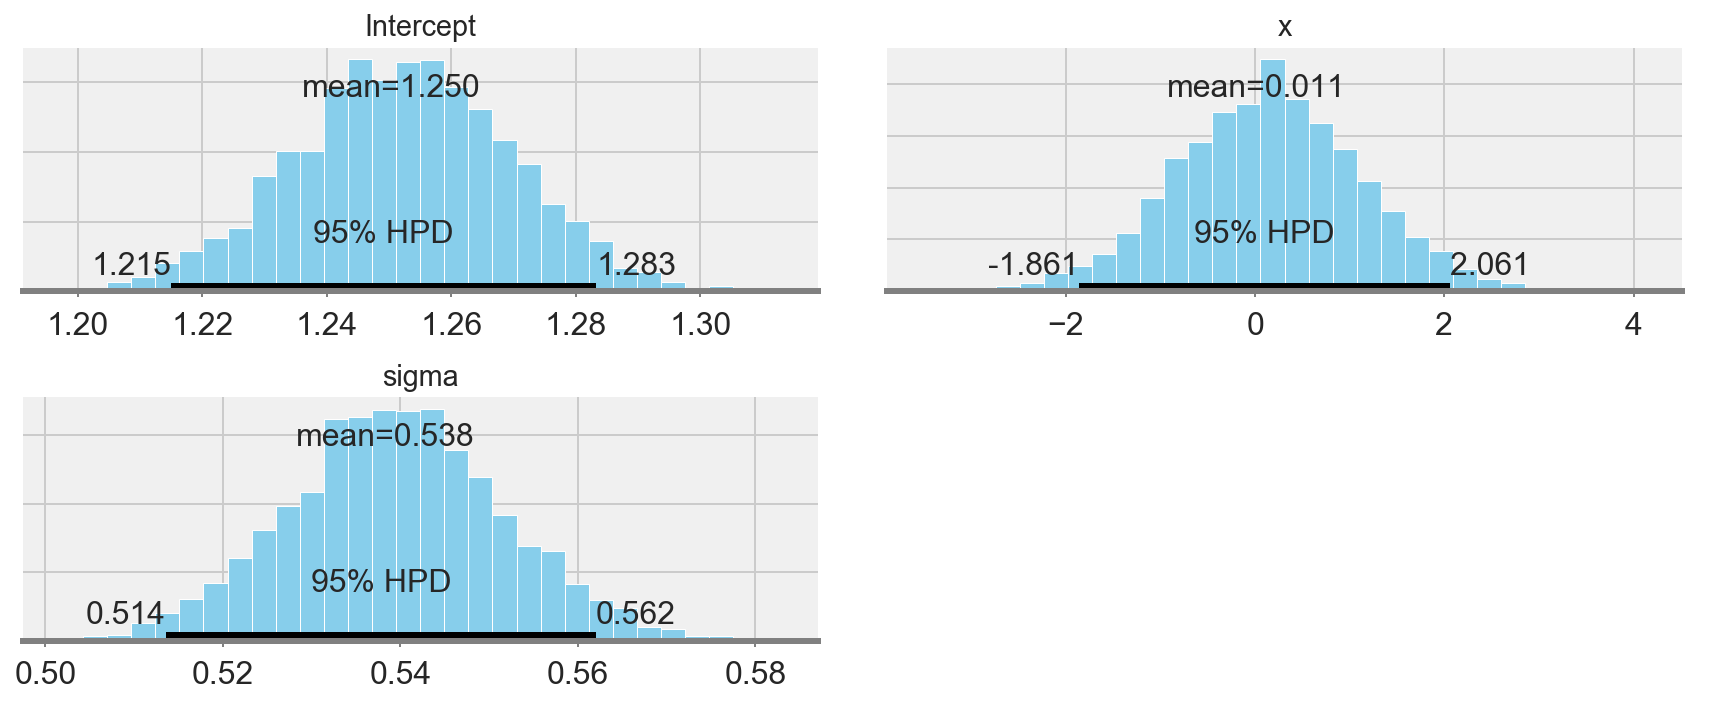

In [108]:
plot_posterior(trace[100:], color = '#87ceeb')